In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda as cuda
from torch.utils.data import DataLoader
import os
import time
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#import timm # Unofficial pytorch image models, for comparison
from PIL import Image
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use Nvidia GPU if available, for faster results 

In [2]:
# Define the transformations that will be applied to the images during the loading process
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Images are 128 x 72, upscaled to 128 x 128  
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std. Dev values used here are commonly used with the ImageNet dataset
])

In [3]:
# Training Settings
batch_size = 32
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 2147483647

In [4]:
# Get Data
# We'll use a PyTorch Generator to make things repeatable (deterministic)
g = torch.Generator().manual_seed(seed)

# Load Data
cwd = os.getcwd()
bg_dataset_path = "%s\\..\\data\\bg\\" % (cwd)
no_bg_dataset_path = "%s\\..\\data\\no_bg\\" % (cwd)
bg_dataset = datasets.ImageFolder(bg_dataset_path, transform=transform) # Automatically assigns labels to examples based on the directory structure
no_bg_dataset = datasets.ImageFolder(no_bg_dataset_path, transform=transform)

# Generate 2 splits: Train (90%), Validation - Hyperparam selection (10%), Test (10%)
bg_dataset_size = len(bg_dataset)
no_bg_dataset_size = len(no_bg_dataset)

bg_train_size = int(0.9 * bg_dataset_size)
no_bg_train_size = int(0.9 * no_bg_dataset_size)

bg_test_size = bg_dataset_size - bg_train_size # - val_size
no_bg_test_size = no_bg_dataset_size - no_bg_train_size

bg_train, bg_test = torch.utils.data.random_split(bg_dataset, [bg_train_size, bg_test_size], generator=g)
no_bg_train, no_bg_test = torch.utils.data.random_split(no_bg_dataset, [no_bg_train_size, no_bg_test_size], generator=g)

# Create Data Loaders for splits
bg_train_dl = DataLoader(bg_train, batch_size=batch_size, shuffle=True)
no_bg_train_dl = DataLoader(no_bg_train, batch_size=batch_size, shuffle=True)

bg_test_dl = DataLoader(bg_test, batch_size=batch_size, shuffle=True)
no_bg_test_dl = DataLoader(no_bg_test, batch_size=batch_size, shuffle=True)

In [5]:
categories = ["acacia", "birch", "darkoak", "jungle", "oak", "spruce"]
    
# Test Attn/Embedding Images
@torch.no_grad()
def load_jpgs():
    cwd = os.getcwd()
    path = "%s\\..\\data\\attn_vis\\" % (cwd)
    bg_path = os.path.join(path, "bg\\")
    no_bg_path = path + "no_bg\\"
    global categories
    bg_output = []
    no_bg_output = []
    for category in categories: 
        file = category + ".jpg"
        bg_file_path = os.path.join(bg_path, category, file)
        no_bg_file_path = os.path.join(no_bg_path, category, file)
        bg_output.append(transform(Image.open(bg_file_path)))
        no_bg_output.append(transform(Image.open(no_bg_file_path)))
            
    return bg_output, no_bg_output

@torch.no_grad()
def plot_mats(mat1, mat2, model_name, category, plot_type):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(mat1, aspect='auto')
    axes[0].set_title(f'Original Image | Class: {category}')
    axes[1].imshow(mat2, aspect='auto')
    axes[1].set_title(f'{plot_type} Visualization of {model_name} Inference on Image')
    plt.tight_layout()
    plt.show()

In [6]:
def train_model(model, name):
    # Loss Function
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    
    background = False
    
    for i in range(2):
        print("")
        print("========================================")
        print("Images With Background" if background else "Images Without Background")
        print("========================================")

        print("")
        print("++++++++++++++++++++++++++++++++++++++++")
        print(f"Training Run [Model: {name}]")
        print("++++++++++++++++++++++++++++++++++++++++")
    
        # Training Time
        start_event = cuda.Event(enable_timing=True)
        end_event = cuda.Event(enable_timing=True)
        # Begin Clock
        start_event.record()
    
        # Training Loop
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_accuracy = 0
    
            for data, label in tqdm(bg_train_dl if background else no_bg_train_dl):
                data = data.to(device)
                label = label.to(device)
        
                output = model(data)
                loss = criterion(output, label)
                #training_loss[f"{name}"].append(loss)
        
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                acc = (output.argmax(dim=1) == label).float().mean()
                #training_accuracy[f"{name}"].append(acc)
                epoch_accuracy += acc / len(bg_train_dl if background else no_bg_train_dl)
                epoch_loss += loss / len(bg_train_dl if background else no_bg_train_dl)
        
            print(f"Epoch: {epoch+1} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}")
       
        # End Clock
        end_event.record()
        cuda.synchronize() # Wait for GPU operations to complete
        time = start_event.elapsed_time(end_event) / 1000 # Convert to seconds
        num_examples = batch_size * len(bg_train_dl if background else no_bg_train_dl)
        time_per_example = time / (num_examples * epochs)
        print(f"It took {time} seconds to train {name} on {num_examples} examples over {epochs} epochs.")
        print(f"That averages to {time_per_example} seconds per example")
        
        print("++++++++++++++++++++++++++++++++++++++++")
        print(f"Test Run [Model: {name}] ")
        print("++++++++++++++++++++++++++++++++++++++++")
        accuracies = []
        batch_acc = 0
        for data, label in tqdm(bg_test_dl if background else no_bg_test_dl):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            acc = (output.argmax(dim=1) == label).float().mean().cpu().detach().numpy()
            batch_acc += acc / len(bg_test_dl if background else no_bg_test_dl)
            accuracies.append(batch_acc)
        
        print(f"Test Accuracy: {accuracies[-1]} - Number of test cases: {len(bg_test_dl if background else no_bg_test_dl) * batch_size}")
        
        print("")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("Covariate Shift Test:")
        print(f"No-Background Images Tested on Background-Trained {name} Model" if background else f"Background Images Tested on No-Background-Trained {name} Model")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        accuracies = []
        batch_acc = 0
        for data, label in tqdm(no_bg_test_dl if background else bg_test_dl):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            acc = (output.argmax(dim=1) == label).float().mean().cpu().detach().numpy()
            batch_acc += acc / len(no_bg_test_dl if background else bg_test_dl)
            accuracies.append(batch_acc)
        print(f"Test Accuracy: {accuracies[-1]} - Number of test cases: {len(no_bg_test_dl if background else bg_test_dl) * batch_size}")
    
        background = True
    

In [ ]:
# Model 1: VanillaViT
from vit_pytorch import ViT

VanillaViT = ViT(
    image_size = 128,
    patch_size = 8,
    num_classes = 6,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(VanillaViT, "VanillaViT")

print("")
print("-------------------------------------------------------------")
print(f"Attention Visualization")
print(f"[Model: name]")
print("-------------------------------------------------------------")
print("")
bg_imgs, no_bg_imgs = load_jpgs()
from vit_pytorch.recorder import Recorder
v = Recorder(VanillaViT)
"""
# Experimenting with attention weight visualization

for index, img in enumerate(bg_imgs):
    img.unsqueeze(0)
    preds, attns = v(img)
    attns
    attns.shape()
    plot_mats(img, attns, 'test', categories[index], 'test_plt')

In [ ]:
# Model 2: SimpleViT 
from vit_pytorch import SimpleViT

SimpleViT = SimpleViT(
    image_size = 128,
    patch_size = 8,
    num_classes = 6,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048
).to(device)
train_model(SimpleViT, "SimpleViT")

In [ ]:
# Model 4: T2TViT
from vit_pytorch.t2t import T2TViT

T2TViT = T2TViT(
    dim = 512,
    image_size = 128,
    depth = 5,
    heads = 8,
    mlp_dim = 512,
    num_classes = 6,
    t2t_layers = ((7, 4), (3, 2), (3, 2)) # tuples of the kernel size and stride of  each consecutive layers of the initial token to token module
).to(device)
train_model(T2TViT, "T2TViT")


In [ ]:
# Model 6: CrossViT
from vit_pytorch.cross_vit import CrossViT

CrossViT = CrossViT(
    image_size = 128,
    num_classes = 6,
    depth = 4,               # number of multi-scale encoding blocks
    sm_dim = 192,            # high res dimension
    sm_patch_size = 16,      # high res patch size (should be smaller than lg_patch_size)
    sm_enc_depth = 2,        # high res depth
    sm_enc_heads = 8,        # high res heads
    sm_enc_mlp_dim = 2048,   # high res feedforward dimension
    lg_dim = 384,            # low res dimension
    lg_patch_size = 64,      # low res patch size
    lg_enc_depth = 3,        # low res depth
    lg_enc_heads = 8,        # low res heads
    lg_enc_mlp_dim = 2048,   # low res feedforward dimensions
    cross_attn_depth = 2,    # cross attention rounds
    cross_attn_heads = 8,    # cross attention heads
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(CrossViT, "CrossViT")

In [ ]:
# Model 7: PiT
from vit_pytorch.pit import PiT

PiT = PiT(
    image_size = 128,
    patch_size = 16,
    dim = 256,
    num_classes = 6,
    depth = (3, 3, 3),     # list of depths, indicating the number of rounds of each stage before a downsample
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(PiT, "PiT")

In [ ]:
# Model 8: LeViT
from vit_pytorch.levit import LeViT

LeViT = LeViT(
    image_size = 128,
    num_classes = 6,
    stages = 3,             # number of stages
    dim = (256, 384, 512),  # dimensions at each stage
    depth = 4,              # transformer of depth 4 at each stage
    heads = (4, 6, 8),      # heads at each stage
    mlp_mult = 2,
    dropout = 0.1
).to(device)
train_model(LeViT, "LeViT")

In [ ]:
# Model 9: CvT
from vit_pytorch.cvt import CvT

CvT = CvT(
    num_classes = 6,
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 1,           # stage 1 - heads
    s1_depth = 1,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 192,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,
    s3_emb_dim = 384,       # stage 3 - (same as above)
    s3_emb_kernel = 3,
    s3_emb_stride = 2,
    s3_proj_kernel = 3,
    s3_kv_proj_stride = 2,
    s3_heads = 4,
    s3_depth = 10,
    s3_mlp_mult = 4,
    dropout = 0.
).to(device)
train_model(CvT, "CvT")

In [ ]:
# Model 13: ScalableViT
from vit_pytorch.scalable_vit import ScalableViT

ScalableViT = ScalableViT(
    num_classes = 6,
    dim = 64,                               # starting model dimension. at every stage, dimension is doubled
    heads = (2, 4, 8, 16),                  # number of attention heads at each stage
    depth = (2, 2, 20, 2),                  # number of transformer blocks at each stage
    ssa_dim_key = (40, 40, 40, 32),         # the dimension of the attention keys (and queries) for SSA. in the paper, they represented this as a scale factor on the base dimension per key (ssa_dim_key / dim_key)
    reduction_factor = (8, 4, 2, 1),        # downsampling of the key / values in SSA. in the paper, this was represented as (reduction_factor ** -2)
    window_size = (32, 16, None, None),     # window size of the IWSA at each stage. None means no windowing needed
    dropout = 0.1,                          # attention and feedforward dropout
).to(device)
train_model(ScalableViT, "ScalableViT")

In [ ]:
# Model 15: MobileViT
from vit_pytorch.mobile_vit import MobileViT

MobileViT = MobileViT(
    image_size = (128, 128),
    dims = [96, 120, 144],
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
    num_classes = 6
).to(device)
train_model(MobileViT, "MobileViT")

In [ ]:
# Model 16: SmallDataViT
from vit_pytorch.vit_for_small_dataset import ViT as SmallDataViT

SmallDataViT = SmallDataViT(
    image_size = 128,
    patch_size = 16,
    num_classes = 6,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
train_model(SmallDataViT, "SmallDataViT")

In [7]:
models = ["VanillaViT", "SimpleViT", "T2TViT", "CrossViT", "PiT", "LeViT", "CvT", "ScalableViT", "MobileViT", "SmallDataViT"]
# Data Pulled from previous run

# ----------------------------------------
# WITH BACKGROUND
# ----------------------------------------

bg_loss = {
    "VanillaViT": [1.8163, 0.1933, 0.0943, 0.0398, 0.0315, 0.0159, 0.0092, 0.0075, 0.0079, 0.0055],
    "SimpleViT": [1.2359, 0.3131, 0.1769, 0.1230, 0.0932, 0.0581, 0.0384, 0.0308, 0.0143, 0.0093],
    "T2TViT": [1.6233, 0.3530, 0.1364, 0.0595, 0.0222, 0.0136, 0.0082, 0.0058, 0.0047, 0.0039],
    "CrossViT": [2.4895, 0.8656, 0.3743, 0.1730, 0.1036, 0.0564, 0.0309, 0.0183, 0.0155, 0.0101],
    "PiT": [1.6899, 0.9295, 0.4737, 0.2556, 0.2185, 0.3068, 0.1892, 0.1375, 0.0715, 0.0448],
    "LeViT": [3.2105, 1.0423, 0.7976, 0.6104, 0.5056, 0.4750, 0.3789, 0.3342, 0.2680, 0.2252],
    "CvT": [0.8507, 0.1811, 0.0778, 0.0572, 0.0363, 0.0261, 0.0104, 0.0120, 0.0108, 0.0171],
    "ScalableViT": [1.7747, 1.7731, 1.7699, 1.7790, 1.7800, 1.7827, 1.8067, 1.7771, 1.7684, 1.7718],
    "MobileViT": [1.7834, 0.4903, 0.3130, 0.1594, 0.1325, 0.1093, 0.0835, 0.0574, 0.0630, 0.0475],
    "SmallDataViT": [1.8399, 0.2607, 0.0762, 0.0308, 0.0157, 0.0106, 0.0075, 0.0061, 0.0050, 0.0043],
}

# Percentage points
bg_accuracy = {
    "VanillaViT": [63.96, 94.74, 97.74, 99.83, 99.65, 100.00, 100.00, 100.00, 100.00, 100.00],
    "SimpleViT": [59.30, 86.73, 93.01, 95.83, 96.97, 98.26, 99.31, 99.48, 100.00, 100.00],
    "T2TViT": [56.80, 91.96, 96.70, 96.70, 99.48, 99.83, 100.00, 100.00, 100.00, 100.00],
    "CrossViT": [38.62, 66.49, 87.48, 93.68, 97.22, 98.96, 99.83, 100.00, 99.83, 100.00],
    "PiT": [35.79, 64.21, 83.21, 89.76, 92.16, 88.94, 92.71, 94.42, 97.54, 98.96],
    "LeViT": [38.81, 60.54, 72.92, 77.31, 81.10, 80.08, 87.95, 92.34, 94.10, 95.76],
    "CvT": [76.02, 93.53, 98.09, 98.54, 98.96, 99.48, 100.00, 99.80, 100.00, 99.08],
    "ScalableViT": [22.31, 18.52, 21.45, 21.10, 19.04, 21.38, 21.47, 18.26, 20.36, 22.62],
    "MobileViT": [45.28, 84.87, 93.29, 97.74, 98.78, 99.13, 99.31, 100.00, 99.83, 100.00],
    "SmallDataViT": [63.56, 92.01, 98.81, 99.67, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00],
}

# Percentage points
bg_test_accuracy = {
    "VanillaViT": 100.00,
    "SimpleViT": 100.00,
    "T2TViT": 98.44,
    "CrossViT": 95.31,
    "PiT": 100.00,
    "LeViT": 93.75,
    "CvT": 100.00,
    "ScalableViT": 20.61,
    "MobileViT": 82.56,
    "SmallDataViT": 98.44,
}

bg_time_to_train_per_example = {
    "VanillaViT": 0.0154,
    "SimpleViT": 0.0139,
    "T2TViT": 0.0051,
    "CrossViT": 0.0038,
    "PiT": 0.0048,
    "LeViT": 0.0025,
    "CvT": 0.0038,
    "ScalableViT": 0.0098,
    "MobileViT": 0.0015,
    "SmallDataViT": 0.0041,
}

bg_covariate_shift_accuracy = {
    "VanillaViT": 39.43,
    "SimpleViT": 41.57,
    "T2TViT": 38.79,
    "CrossViT": 29.85,
    "PiT": 26.42,
    "LeViT": 45.20,
    "CvT": 44.26,
    "ScalableViT": 17.19,
    "MobileViT": 62.50,
    "SmallDataViT": 28.13,
}



# ----------------------------------------
# Without Background
# ----------------------------------------
no_bg_loss = {
    "VanillaViT": [1.7303, 0.9385, 0.4546, 0.2476, 0.1480, 0.0914, 0.0568, 0.0313, 0.0403, 0.0352],
    "SimpleViT": [1.6591, 0.7518, 0.2889, 0.1807, 0.1082, 0.0416, 0.0130, 0.0292, 0.0756, 0.0080],
    "T2TViT": [1.7803, 1.3277, 0.6795, 0.3852, 0.2185, 0.1569, 0.0847, 0.0636, 0.0300, 0.0885],
    "CrossViT": [1.6870, 0.9320, 0.6119, 0.4907, 0.3944, 0.3170, 0.2699, 0.2326, 0.1631, 0.1152],
    "PiT": [1.9349, 1.8263, 1.8196, 1.8255, 1.8130, 1.8024, 1.6980, 1.3395, 0.9765, 0.7308],
    "LeViT": [1.7923, 1.7848, 1.4612, 0.9679, 0.7649, 0.7330, 0.5959, 0.4876, 0.3707, 0.3665],
    "CvT": [1.2049, 0.6850, 0.4215, 0.3020, 0.1891, 0.1331, 0.0827, 0.0922, 0.0636, 0.0414],
    "ScalableViT": [1.8716, 1.8206, 1.8159, 1.8247, 1.8202, 1.8081, 1.8268, 1.8073, 1.8194, 1.8082],
    "MobileViT": [1.6471, 1.1410, 0.7766, 0.5468, 0.3947, 0.2306, 0.1550, 0.1255, 0.1073, 0.0829],
    "SmallDataViT": [1.7844, 1.1780, 0.5257, 0.2646, 0.1669, 0.1141, 0.0644, 0.0442, 0.0449, 0.0325],
}

# Percentage points
no_bg_accuracy = {
    "VanillaViT": [26.93, 66.50, 83.41, 91.82, 95.45, 96.78, 98.25, 99.22, 98.58, 98.81],
    "SimpleViT": [31.62, 72.06, 89.84, 93.24, 96.42, 98.67, 99.82, 98.90, 97.84, 99.86],
    "T2TViT": [22.06, 45.68, 74.31, 85.57, 92.74, 94.62, 97.10, 97.84, 99.31, 96.97],
    "CrossViT": [31.99, 63.56, 77.11, 81.94, 85.20, 88.05, 90.63, 91.50, 93.89, 95.82],
    "PiT": [16.77, 17.05, 18.20, 17.60, 17.56, 18.47, 25.23, 45.96, 61.99, 73.71],
    "LeViT": [16.77, 19.67, 38.74, 55.42, 62.45, 65.03, 74.82, 79.32, 84.65, 85.62],
    "CvT": [51.61, 73.58, 84.65, 89.15, 92.97, 94.99, 97.24, 96.74, 98.12, 98.58],
    "ScalableViT": [15.94, 16.90, 17.81, 17.41, 16.58, 17.41, 17.63, 16.45, 16.49, 18.01],
    "MobileViT": [36.18, 63.04, 74.77, 83.52, 90.78, 97.24, 98.03, 97.76, 98.21, 98.77],
    "SmallDataViT": [23.16, 55.67, 82.91, 91.55, 94.67, 96.14, 98.12, 98.67, 98.53, 99.17],
}

# Percentage points
no_bg_test_accuracy = {
    "VanillaViT": 90.67,
    "SimpleViT": 94.53,
    "T2TViT": 93.36,
    "CrossViT": 86.42,
    "PiT": 73.18,
    "LeViT": 79.34,
    "CvT": 85.98,
    "ScalableViT": 18.75,
    "MobileViT": 71.10,
    "SmallDataViT": 95.31,
}

no_bg_time_to_train_per_example = {
    "VanillaViT": 0.0154,
    "SimpleViT": 0.0139,
    "T2TViT": 0.0050,
    "CrossViT": 0.0032,
    "PiT": 0.0048,
    "LeViT": 0.0024,
    "CvT": 0.0037,
    "ScalableViT": 0.101,
    "MobileViT": 0.0015,
    "SmallDataViT": 0.0041,
}

# Percentage points
no_bg_covariate_shift_accuracy = {
    "VanillaViT": 46.88,
    "SimpleViT": 25.00,
    "T2TViT": 40.63,
    "CrossViT": 20.31,
    "PiT": 25.00,
    "LeViT": 15.63,
    "CvT": 0.375,
    "ScalableViT": 14.31,
    "MobileViT": 15.83,
    "SmallDataViT": 36.49,
}

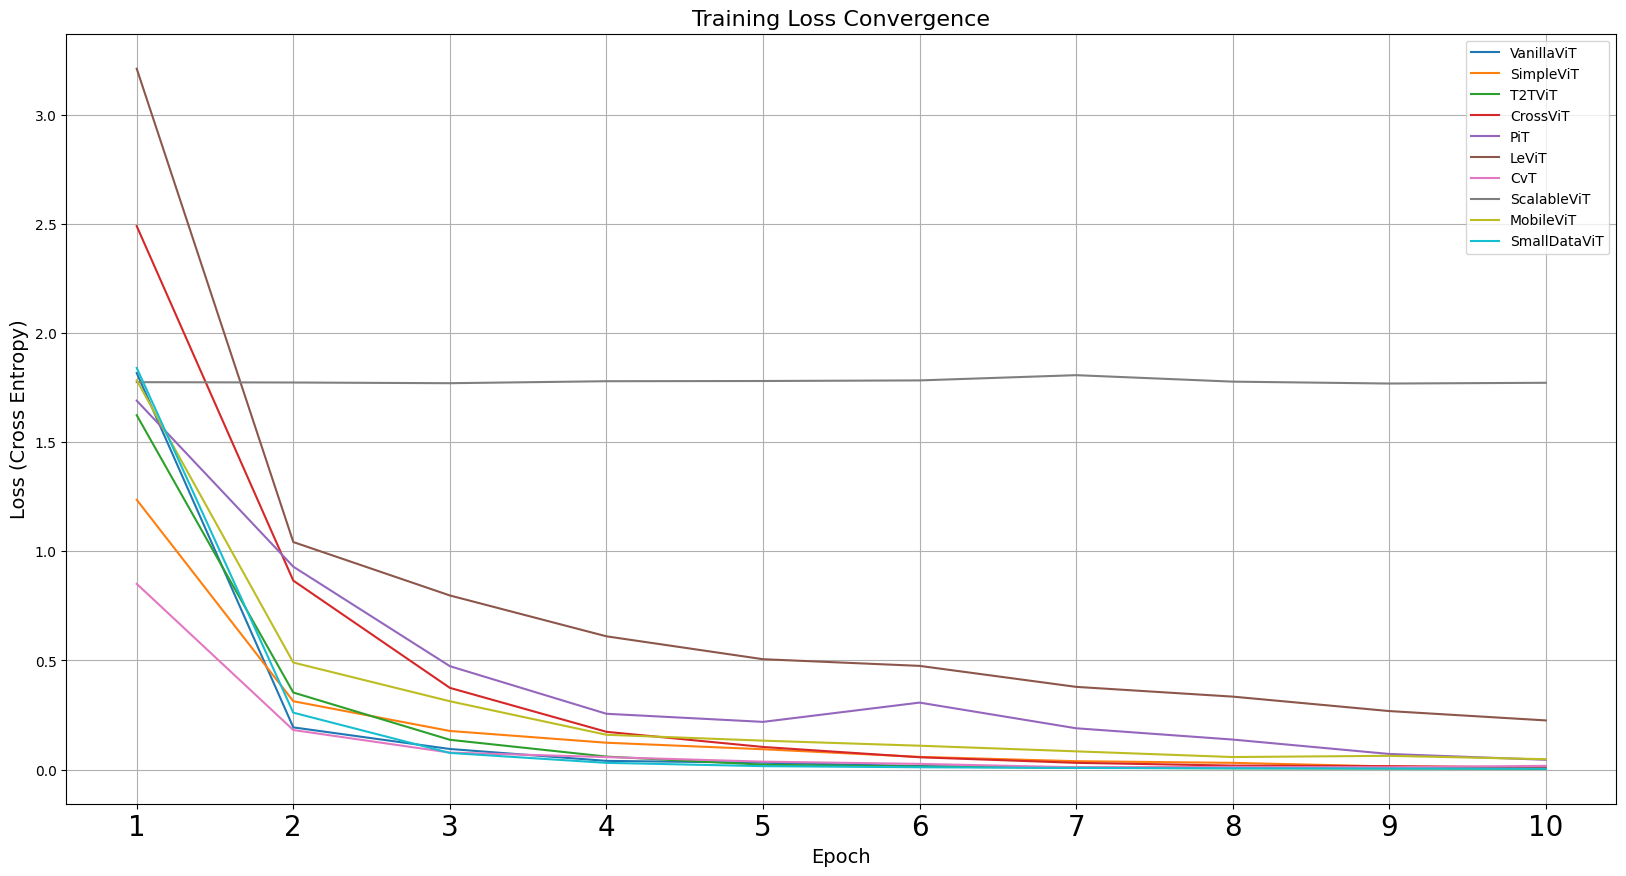

In [21]:
# Background Loss
plt.figure(figsize=(20,10))
for model in models:
    loss_list = bg_loss[model]
    plt.plot(loss_list, label=model)

plt.xticks(range(0,10), labels=range(1,11))
plt.grid(True)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss (Cross Entropy)", fontsize=14)
plt.title("Training Loss Convergence", fontsize=16)
plt.legend()

plt.show()

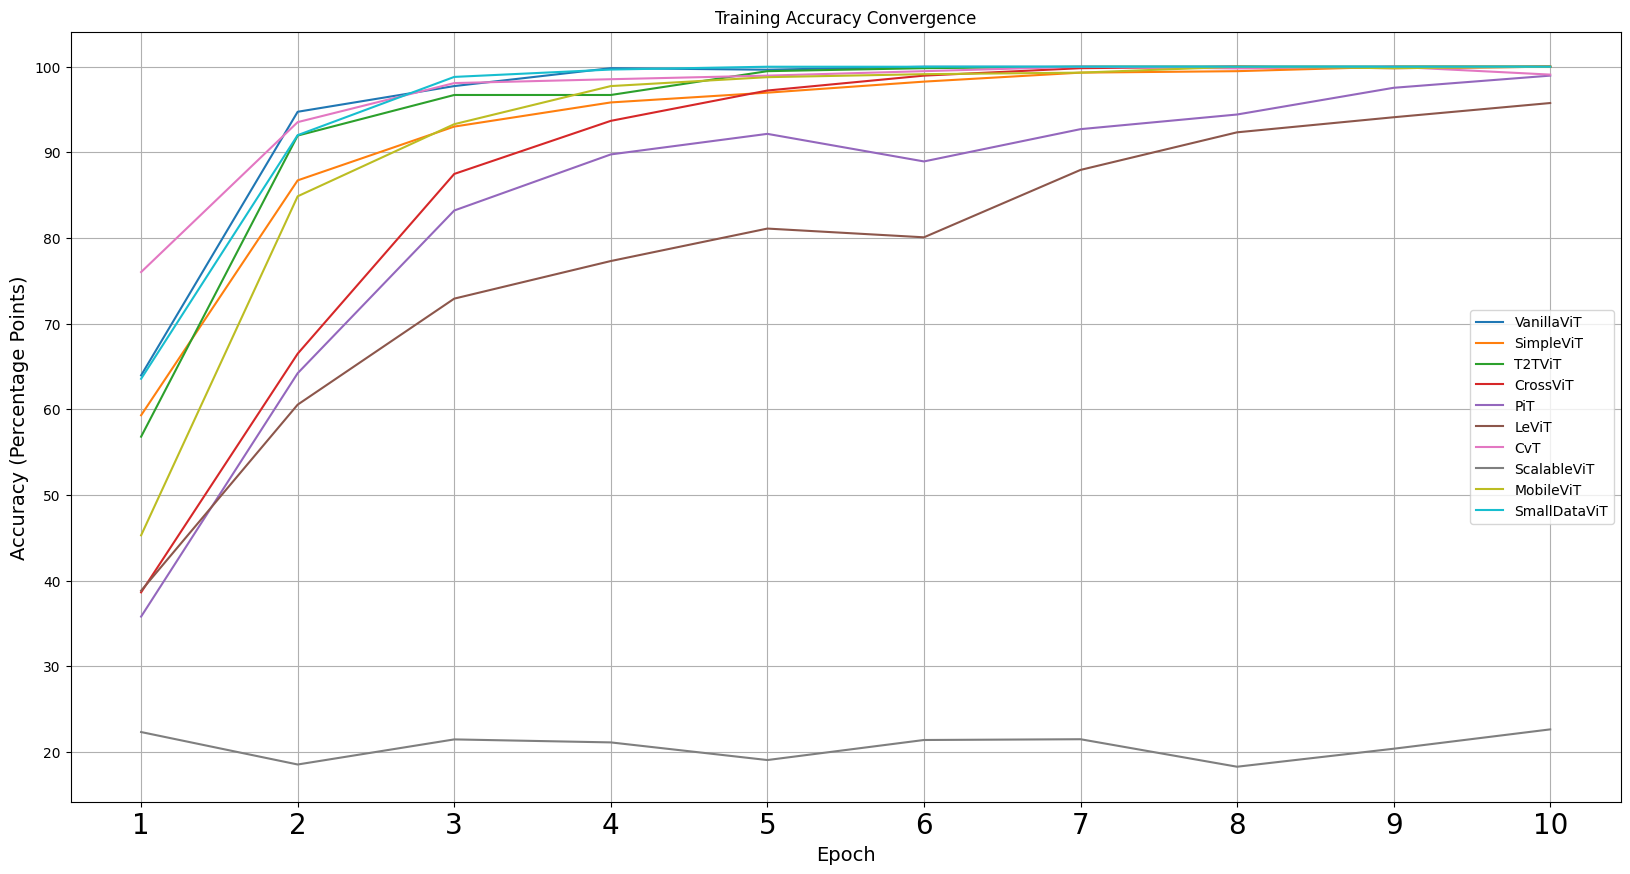

In [22]:
# Background Accuracy
plt.figure(figsize=(20,10))
for model in models:
    acc_list = bg_accuracy[model]
    plt.plot(acc_list, label=model)

plt.xticks(range(0,10), labels=range(1,11))
plt.grid(True)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy (Percentage Points)", fontsize=14)
plt.title("Training Accuracy Convergence")
plt.legend()

plt.show()

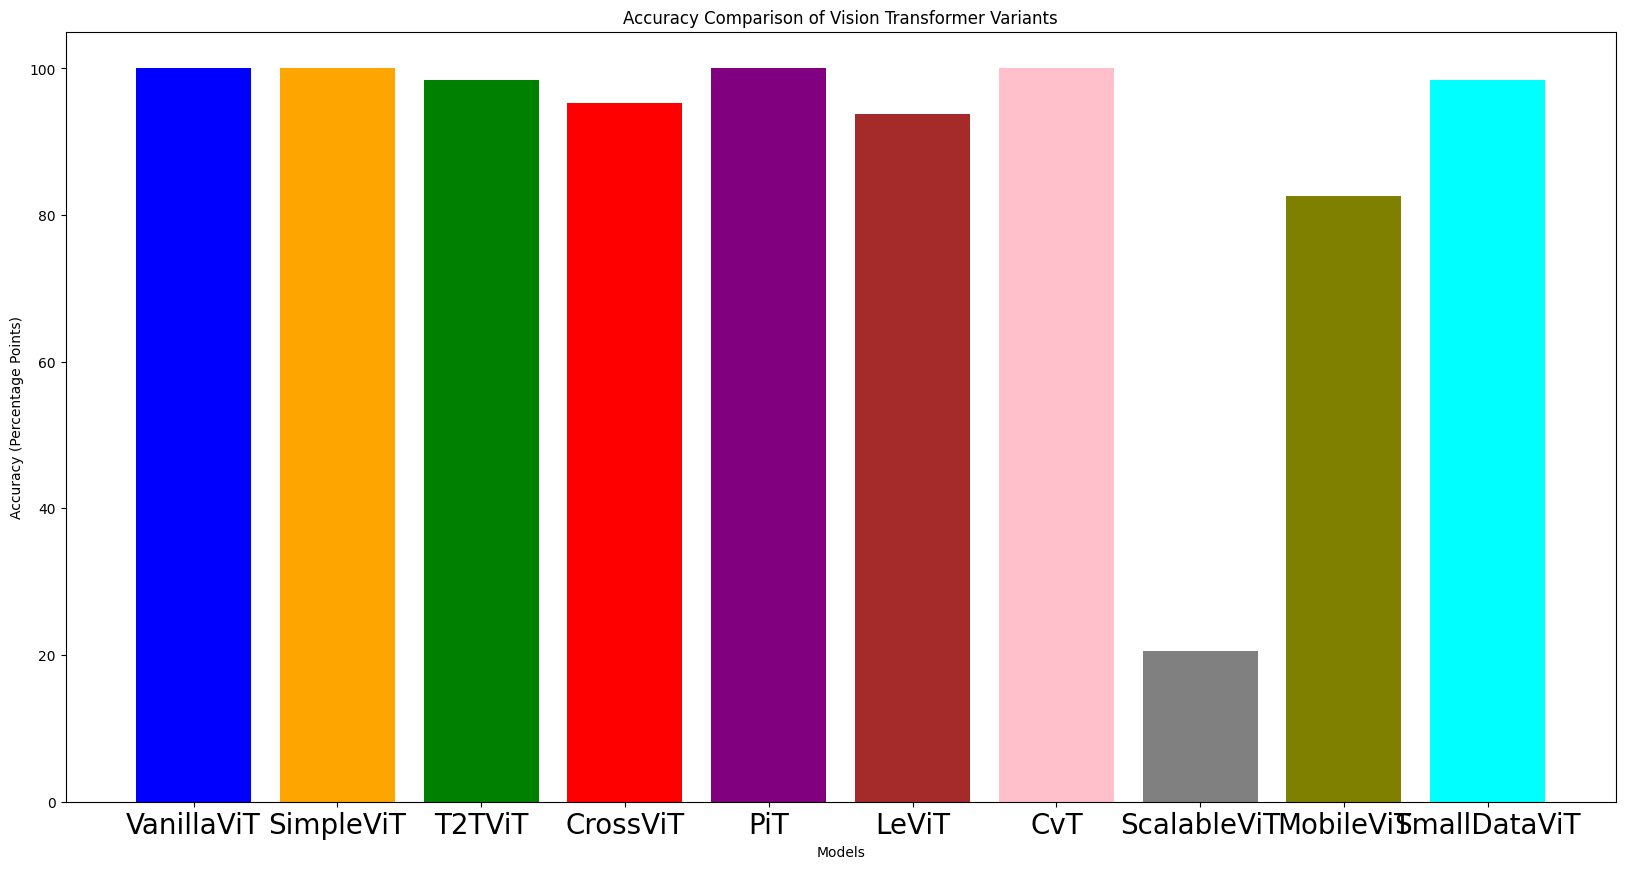

In [25]:
# Training Accuracy
acc_list = []
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan' ]
for model in models:
    acc_list.append(bg_test_accuracy[model])

plt.figure(figsize=(20,10))
plt.bar(models, acc_list, color=colors)
plt.xlabel("Models")
plt.ylabel("Accuracy (Percentage Points)")
plt.title("Accuracy Comparison of Vision Transformer Variants")
plt.show()

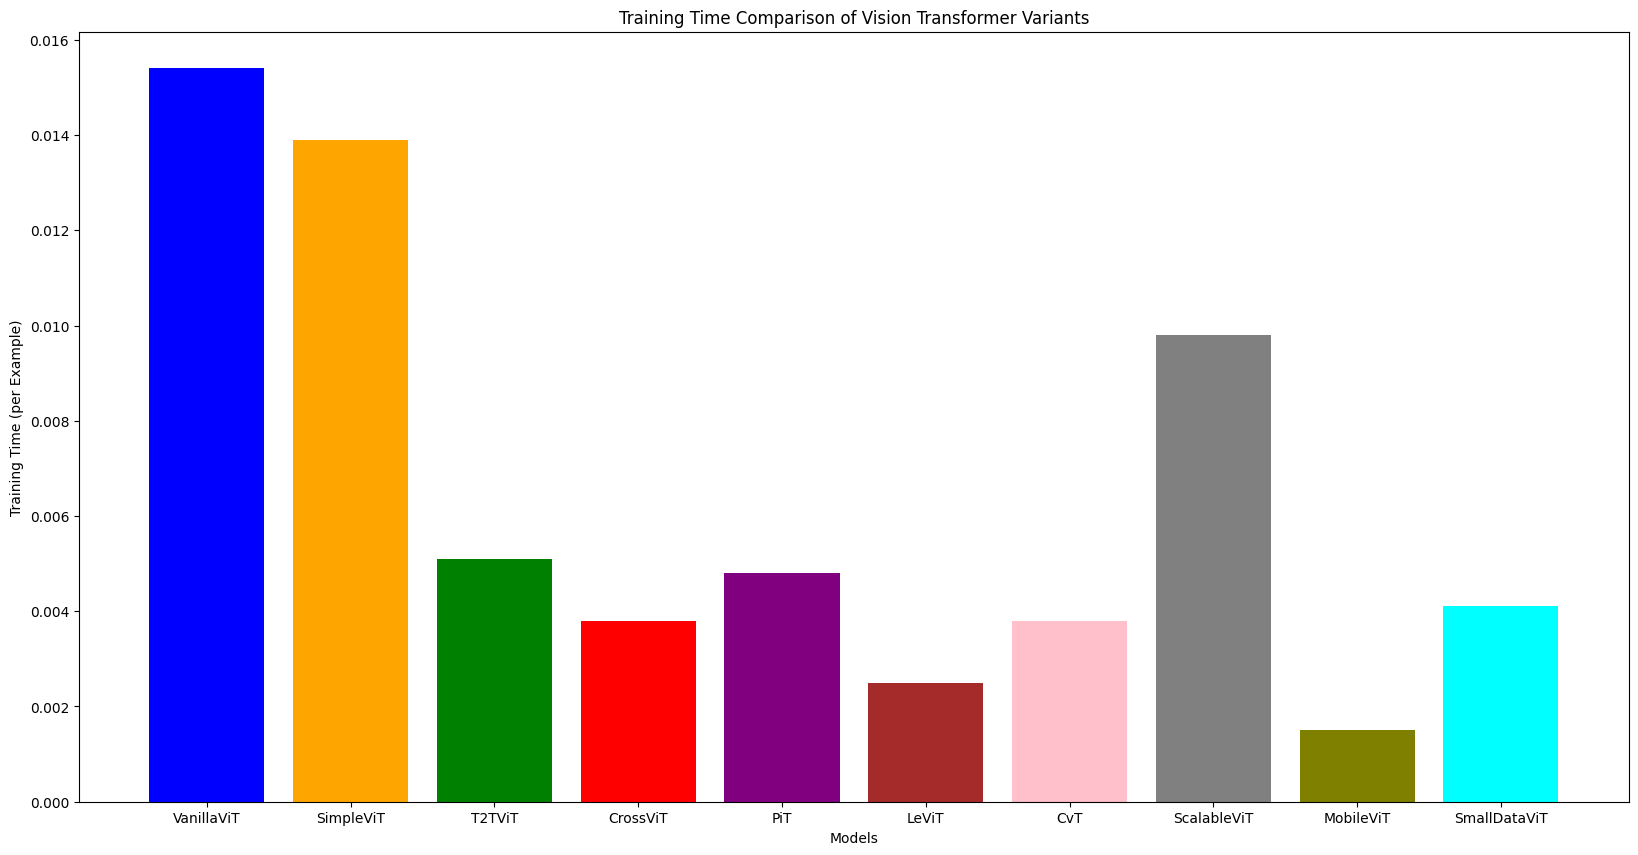

In [11]:
# Training Time
times_list = []
for model in models:
    times_list.append(bg_time_to_train_per_example[model])
    
plt.figure(figsize=(20, 10))
plt.bar(models, times_list, color=colors)
plt.xlabel("Models")
plt.ylabel("Training Time (per Example)")
plt.title("Training Time Comparison of Vision Transformer Variants")
plt.show()

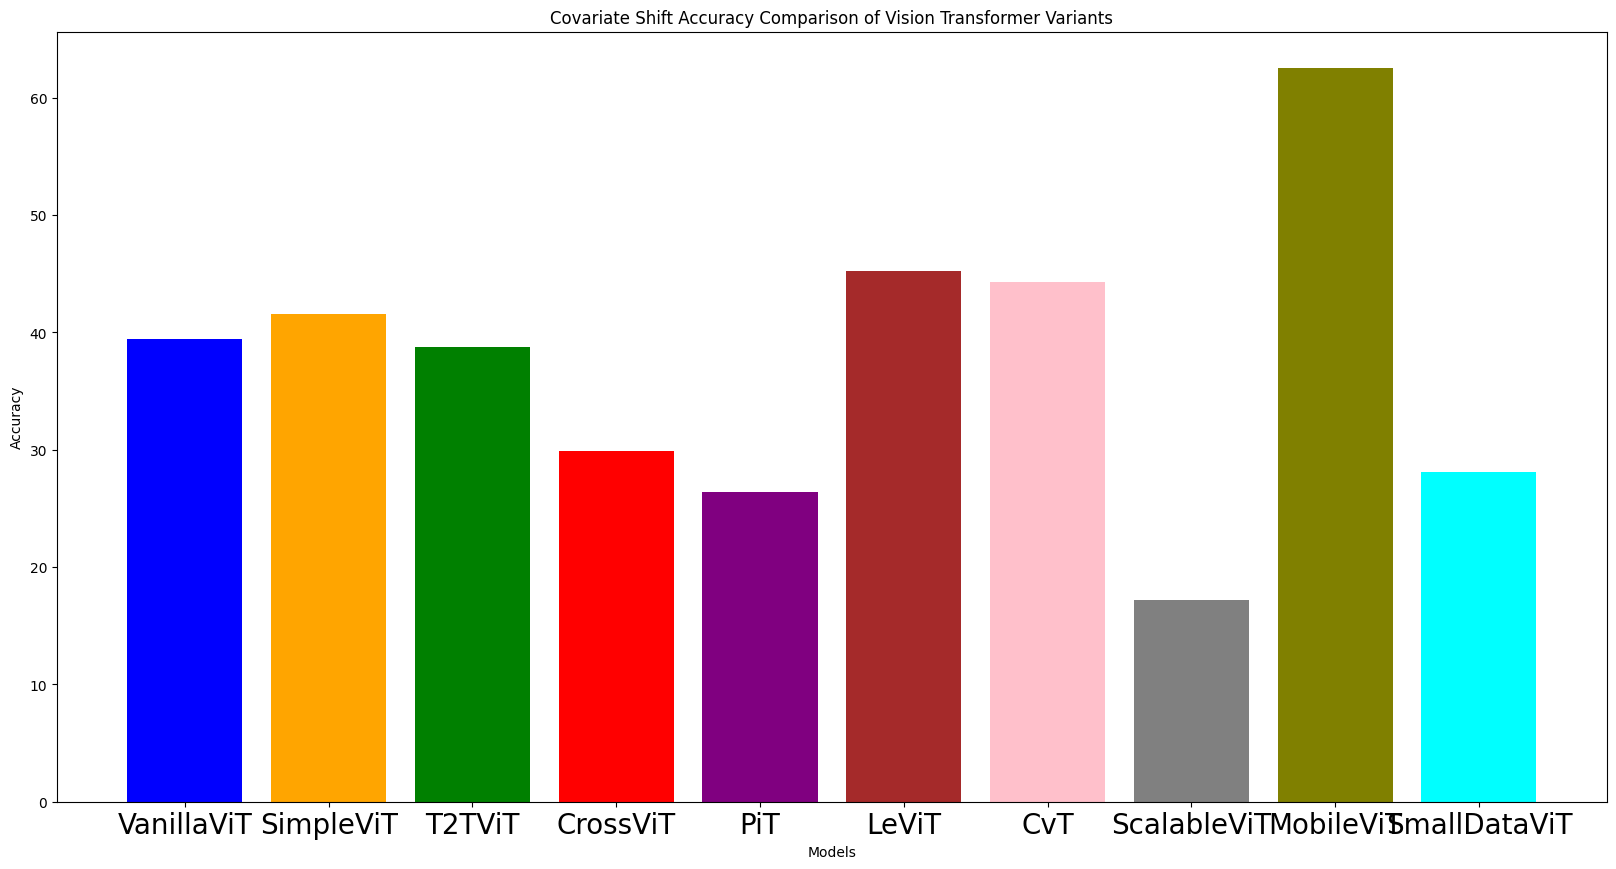

In [26]:
# Covariate Shift Accuracy
acc_list = []
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan' ]
for model in models:
    acc_list.append(bg_covariate_shift_accuracy[model])

plt.figure(figsize=(20,10))
plt.bar(models, acc_list, color=colors)
plt.rc('xtick')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Covariate Shift Accuracy Comparison of Vision Transformer Variants")
plt.show()

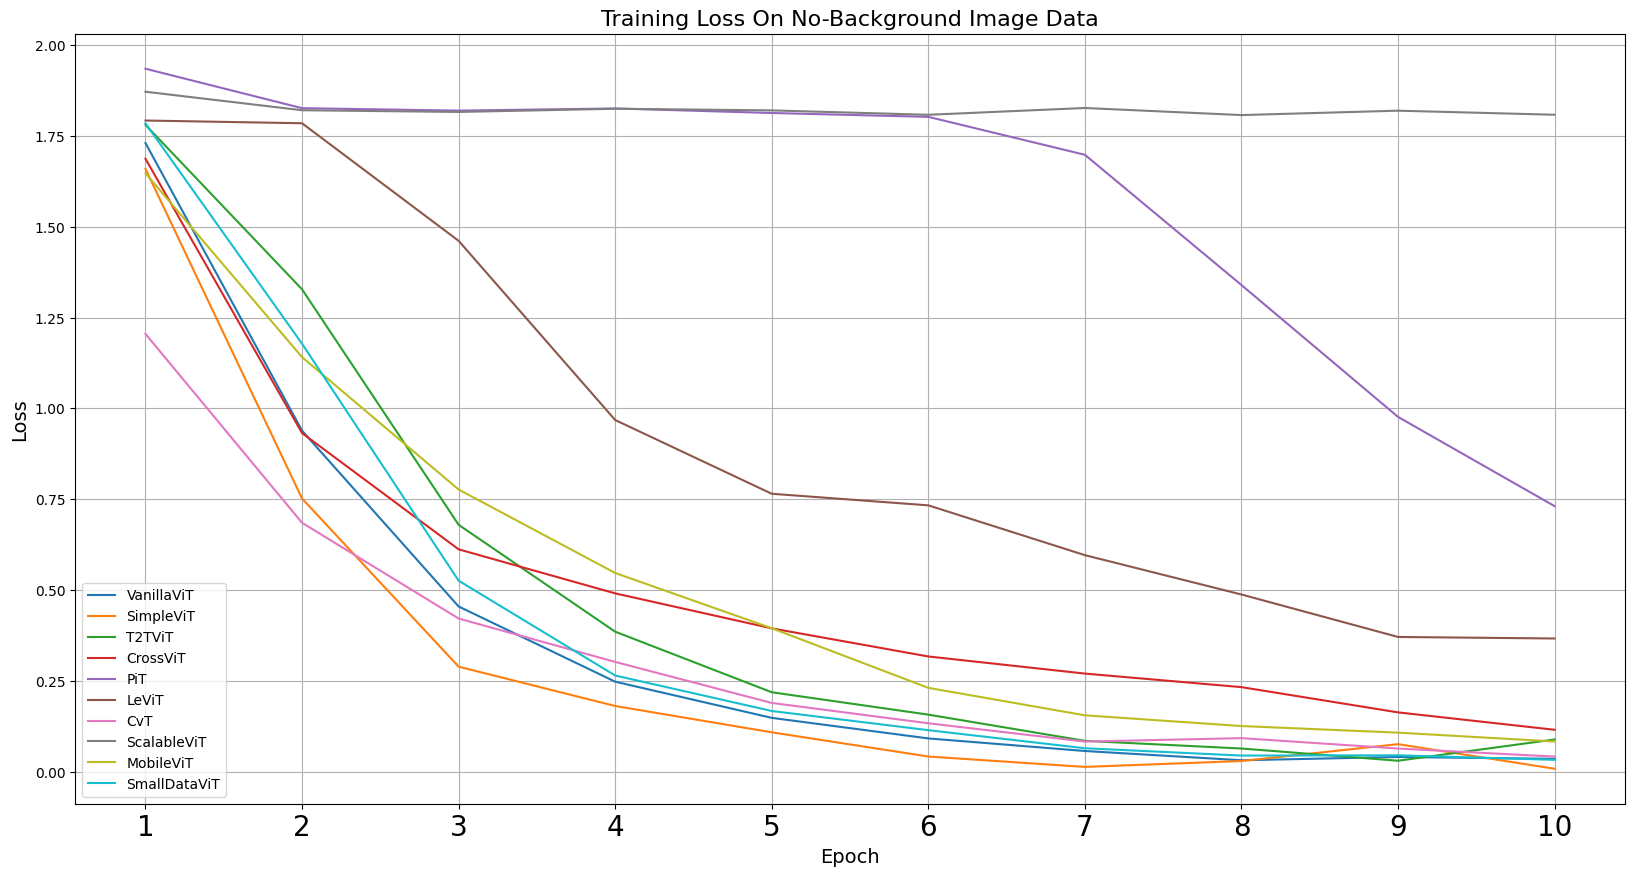

In [13]:
# No-Background Loss
plt.figure(figsize=(20,10))
for model in models:
    loss_list = no_bg_loss[model]
    plt.plot(loss_list, label=model)

plt.xticks(range(0,10), labels=range(1,11))
plt.grid(True)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training Loss On No-Background Image Data", fontsize=16)
plt.legend()

plt.show()

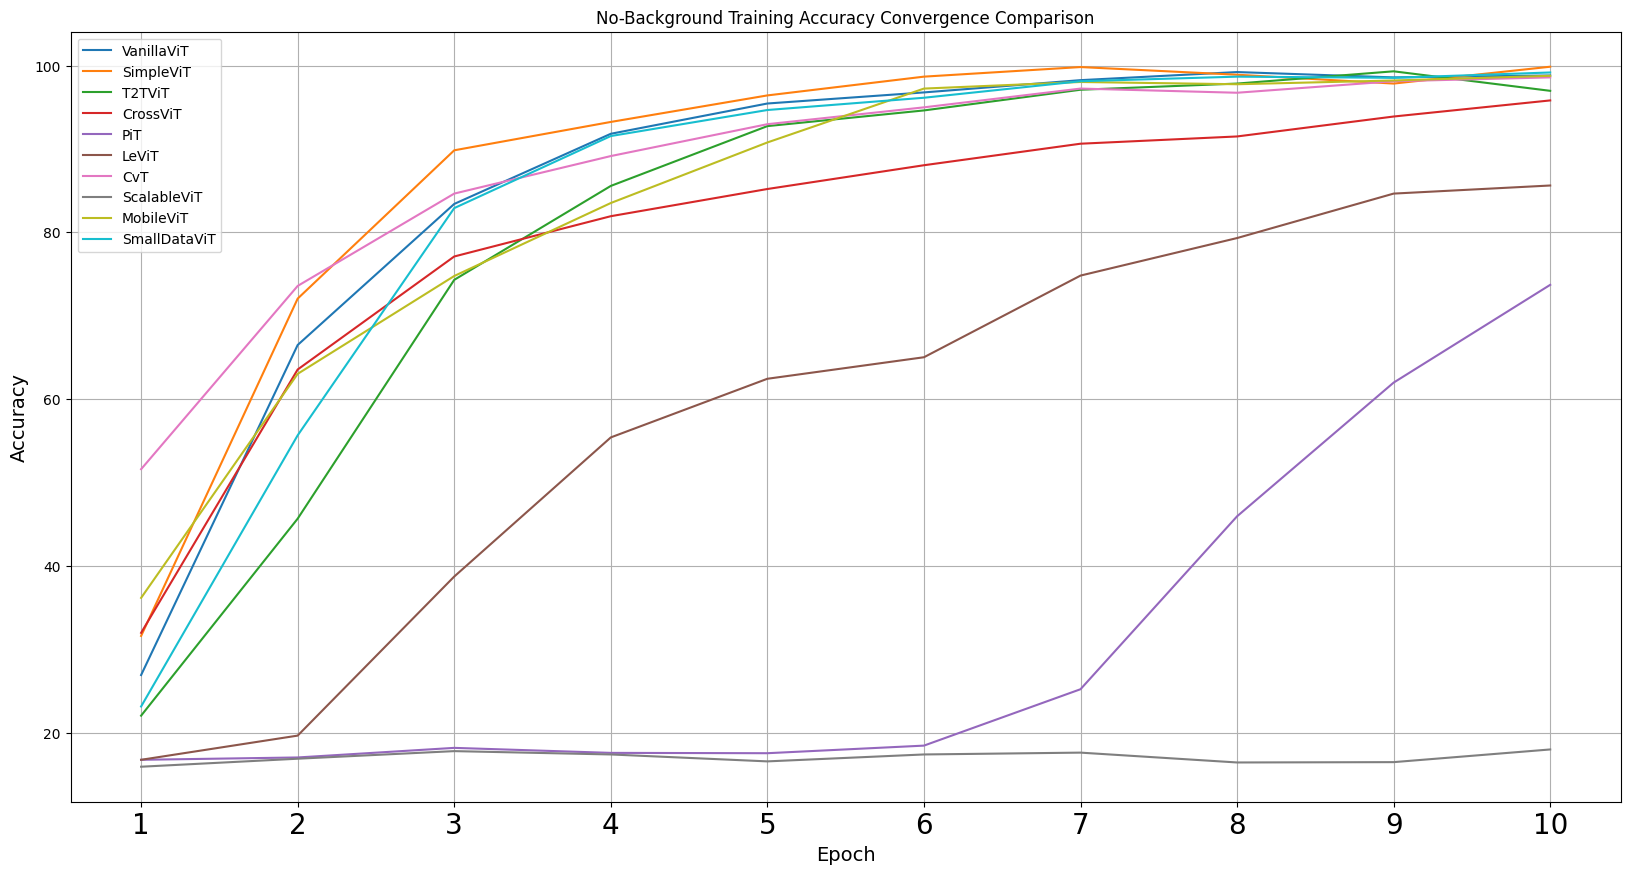

In [14]:
# No-Background Accuracy
plt.figure(figsize=(20,10))
for model in models:
    acc_list = no_bg_accuracy[model]
    plt.plot(acc_list, label=model)

plt.xticks(range(0,10), labels=range(1,11))
plt.grid(True)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("No-Background Training Accuracy Convergence Comparison")
plt.legend()

plt.show()

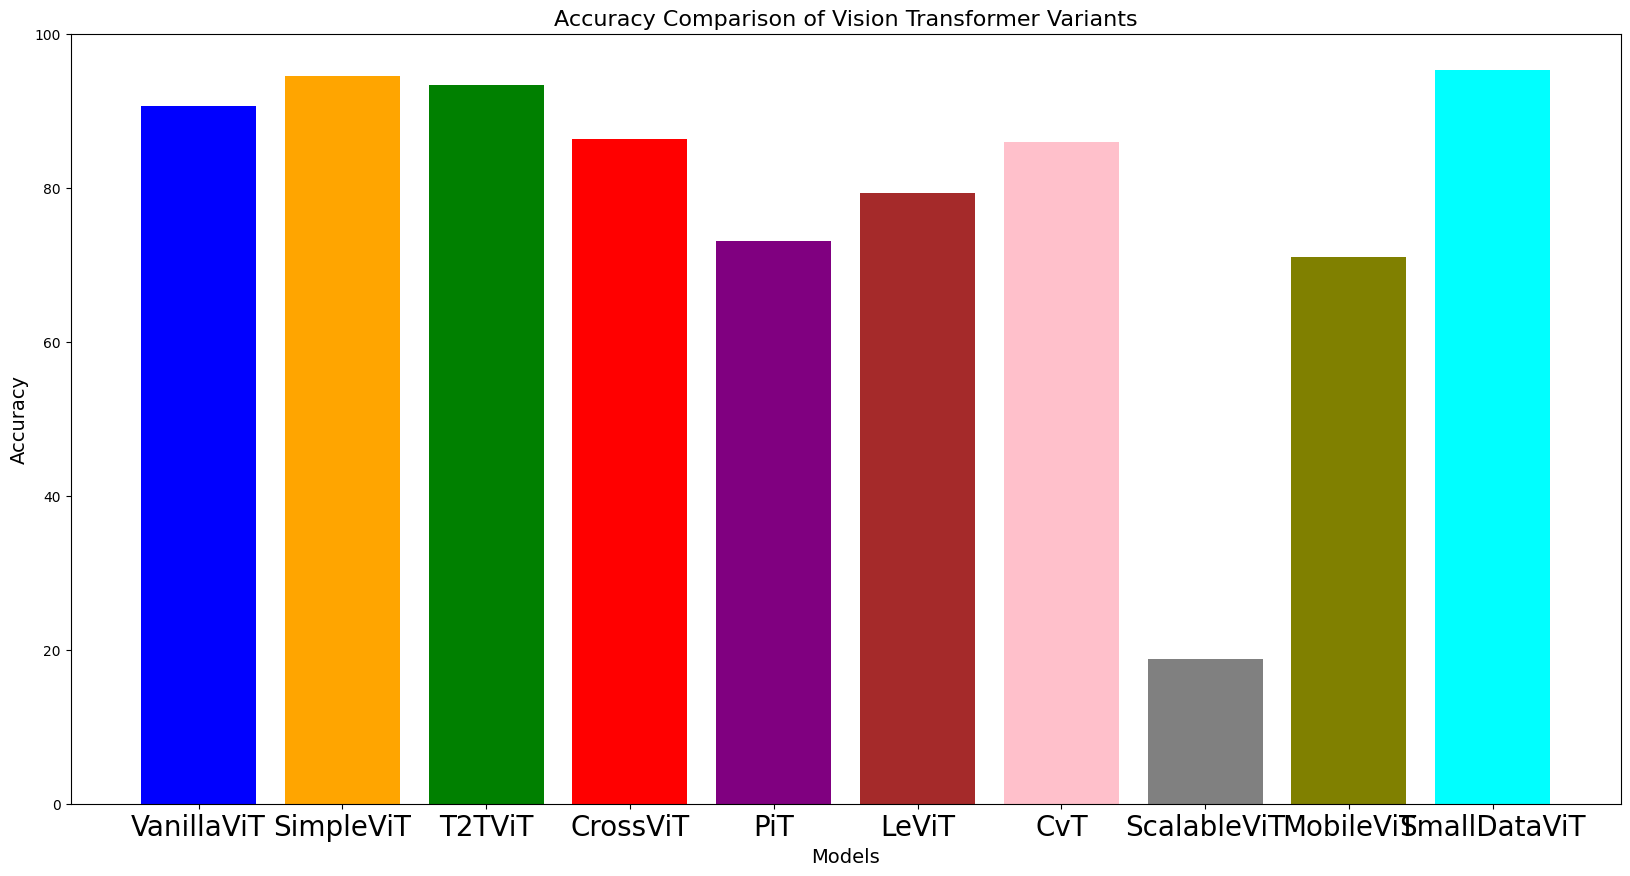

In [15]:
# No-Background Test Accuracy
acc_list = []
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan' ]
for model in models:
    acc_list.append(no_bg_test_accuracy[model])

plt.figure(figsize=(20,10))
plt.bar(models, acc_list, color=colors)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy Comparison of Vision Transformer Variants", fontsize=16)
plt.show()

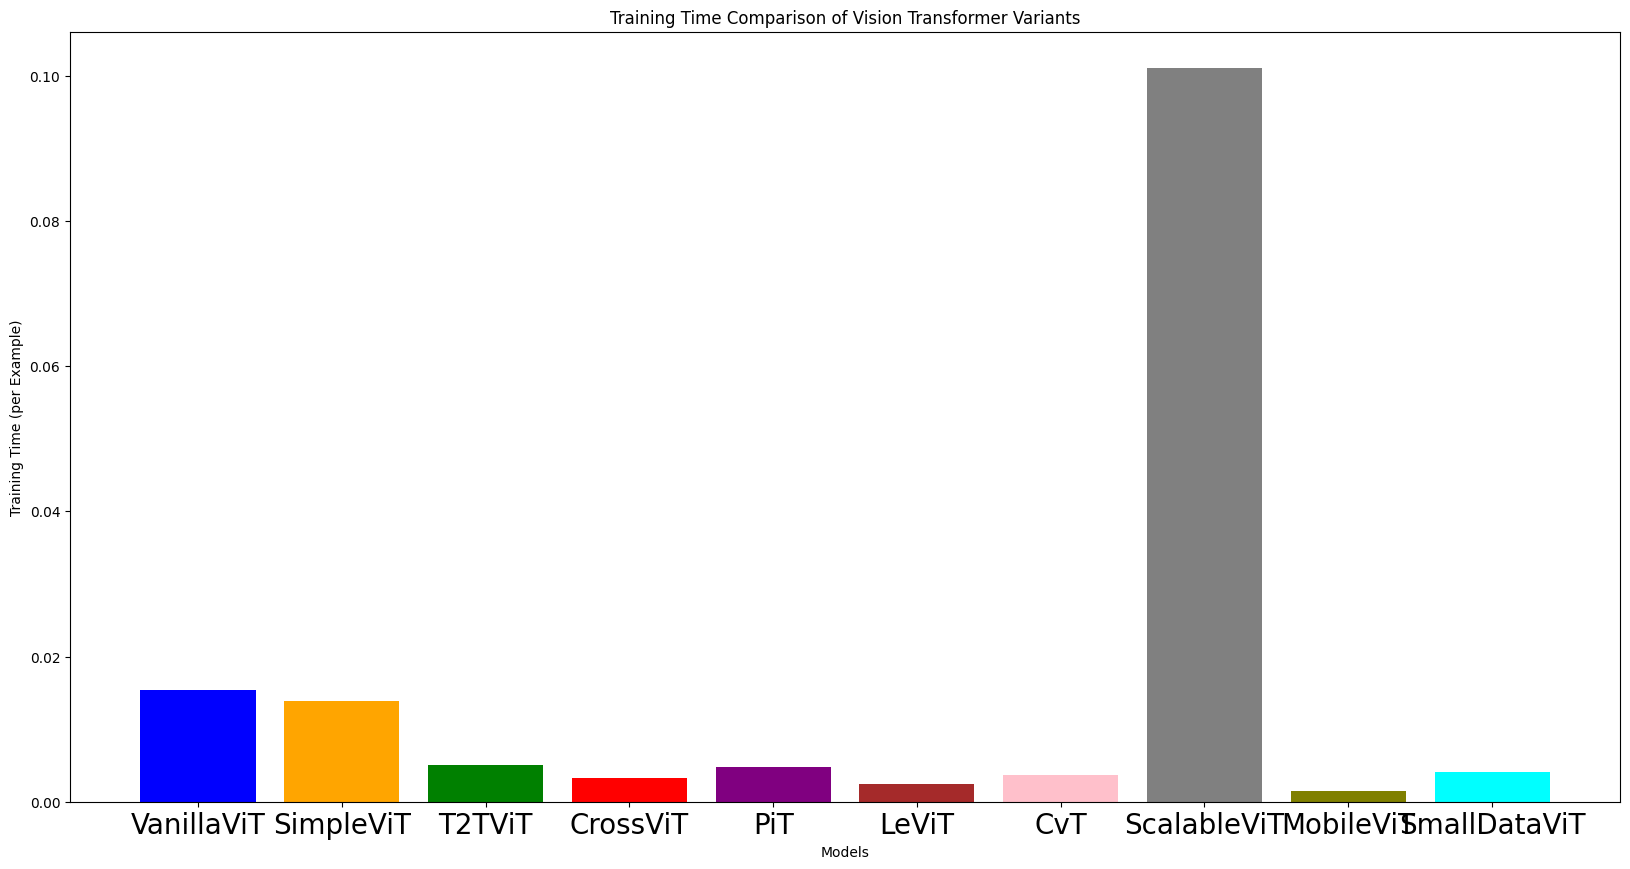

In [16]:
# No-Background Training Time
times_list = []
for model in models:
    times_list.append(no_bg_time_to_train_per_example[model])
    
plt.figure(figsize=(20, 10))
plt.bar(models, times_list, color=colors)
plt.xlabel("Models")
plt.ylabel("Training Time (per Example)")
plt.title("Training Time Comparison of Vision Transformer Variants")
plt.show()

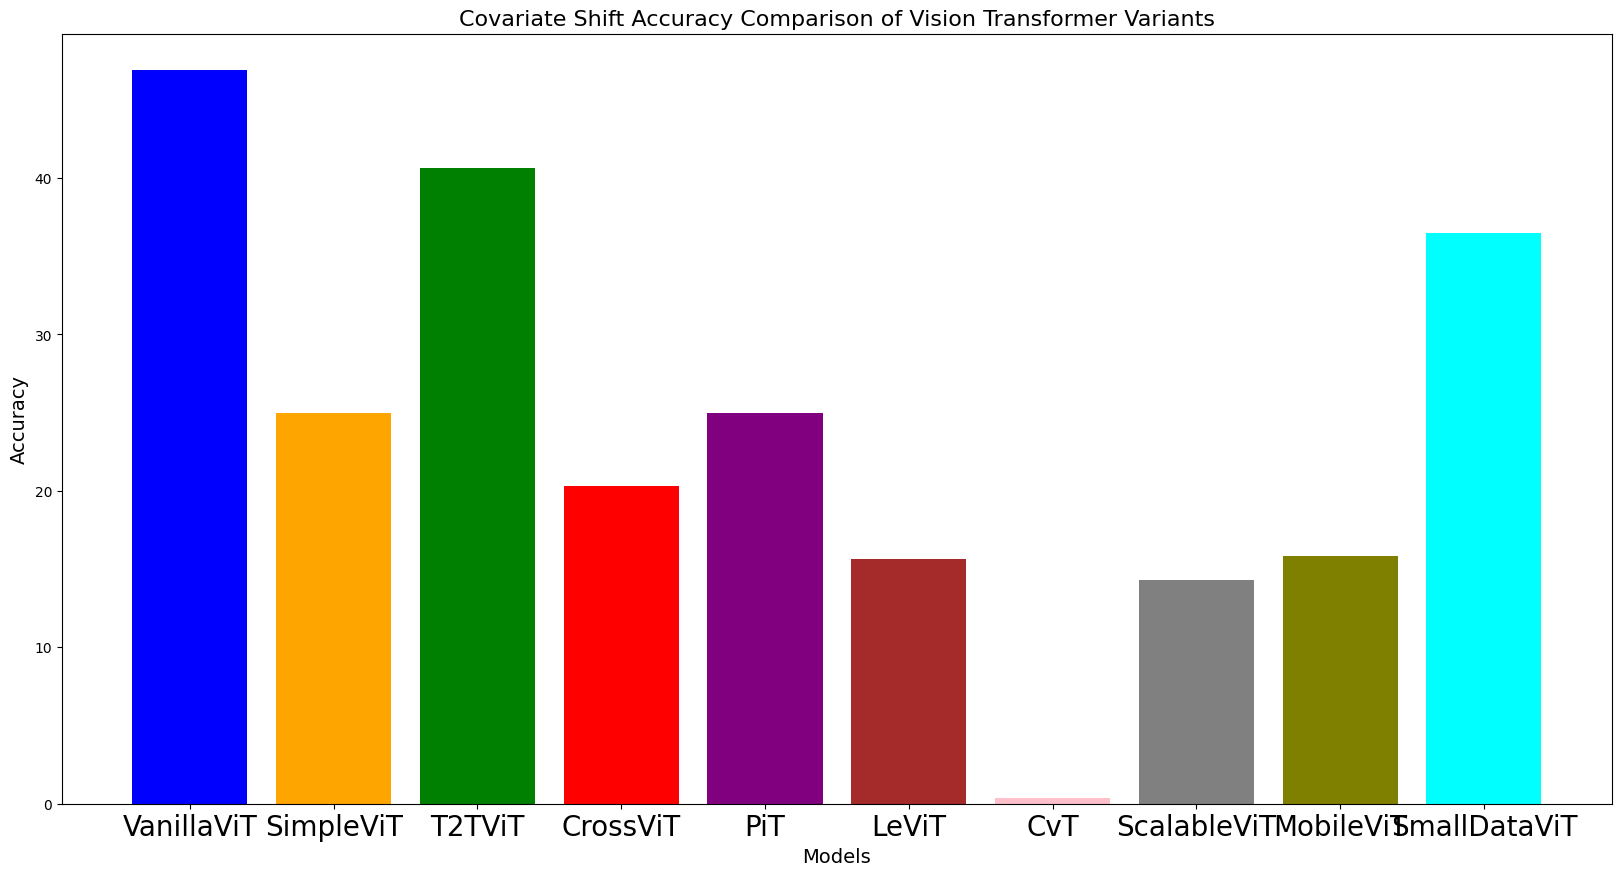

In [17]:
# No-Background Covariate Shift Accuracy
acc_list = []
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan' ]
for model in models:
    acc_list.append(no_bg_covariate_shift_accuracy[model])

plt.figure(figsize=(20,10))
plt.bar(models, acc_list, color=colors)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Covariate Shift Accuracy Comparison of Vision Transformer Variants", fontsize=16)
plt.show()